In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_curve, auc, roc_auc_score
import graphviz
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('German_Credit_Data.csv')
df.head()

,checkin_acc,duration,credit_history,amount,savings_acc,present_emp_since,inst_rate,personal_status,residing_since,age,inst_plans,num_credits,job,status
0,A11,6,A34,1169,A65,A75,4,A93,4,67,A143,2,A173,0
1,A12,48,A32,5951,A61,A73,2,A92,2,22,A143,1,A173,1
2,A14,12,A34,2096,A61,A74,2,A93,3,49,A143,1,A172,0
3,A11,42,A32,7882,A61,A74,2,A93,4,45,A143,1,A173,0
4,A11,24,A33,4870,A61,A73,3,A93,4,53,A143,2,A173,1


In [3]:
#getting dummy variables for categorical features
categoricals = ['checkin_acc', 'credit_history', 'savings_acc', 'present_emp_since', 'personal_status', 'inst_plans', 'job']
dummy_df = pd.get_dummies(df, columns=categoricals)
dummy_df.head()

,duration,amount,inst_rate,residing_since,age,num_credits,status,checkin_acc_A11,checkin_acc_A12,checkin_acc_A13,...,personal_status_A92,personal_status_A93,personal_status_A94,inst_plans_A141,inst_plans_A142,inst_plans_A143,job_A171,job_A172,job_A173,job_A174
0,6,1169,4,4,67,2,0,1,0,0,...,0,1,0,0,0,1,0,0,1,0
1,48,5951,2,2,22,1,1,0,1,0,...,1,0,0,0,0,1,0,0,1,0
2,12,2096,2,3,49,1,0,0,0,0,...,0,1,0,0,0,1,0,1,0,0
3,42,7882,2,4,45,1,0,1,0,0,...,0,1,0,0,0,1,0,0,1,0
4,24,4870,3,4,53,2,1,1,0,0,...,0,1,0,0,0,1,0,0,1,0


## 1. Use the German credit rating dataset “German Credit Data.csv” , Decision tree classifier to predict good or bad credit. Use “sklearn.model_selection” and GridSearchCV to search the hyperparameter values and report the most optimal one. Configure the grid search to search for optimal parameters: 
### • Splitting criteria: gini or entropy.
### • Maximum depth of decision tree ranging from 2 to 10.
### • The searching of optimal parameter will be validated using 10-fold cross validation and the most optimal parameter will be chosen based on ROC AUC score.

In [4]:
#splitting data into training and test
X = dummy_df.drop('status', axis=1)
y = dummy_df['status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)


#initialising GridSearchCV and DecisionTreeClassifier

dtc = DecisionTreeClassifier(random_state=42) #default splitting criteria is gini

params = ({'criterion' : ['gini', 'entropy'], 'max_depth' : list(range(2,10))})
gcv = GridSearchCV(dtc, params, cv=10, scoring = 'roc_auc')
gcv.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 4, 5, 6, 7, 8, 9]},
             scoring='roc_auc')

In [5]:
#checking the best score for GridSearchCV
print('Best Score: ', gcv.best_score_)

#checking the best parameter combination
print('Best Parameters: ', gcv.best_params_)

Best Score:  0.6947320112209366
Best Parameters:  {'criterion': 'gini', 'max_depth': 4}


In [6]:
#fitting the classifier with optimal parameters
dtc_model = DecisionTreeClassifier(max_depth=4, criterion='gini')
dtc_model.fit(X_train, y_train)
y_pred = dtc_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.716

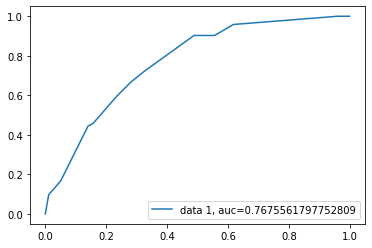

In [7]:
#plotting the roc curve
y_pred_proba = dtc_model.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

## 2. Visualize the tree using graphviz software.

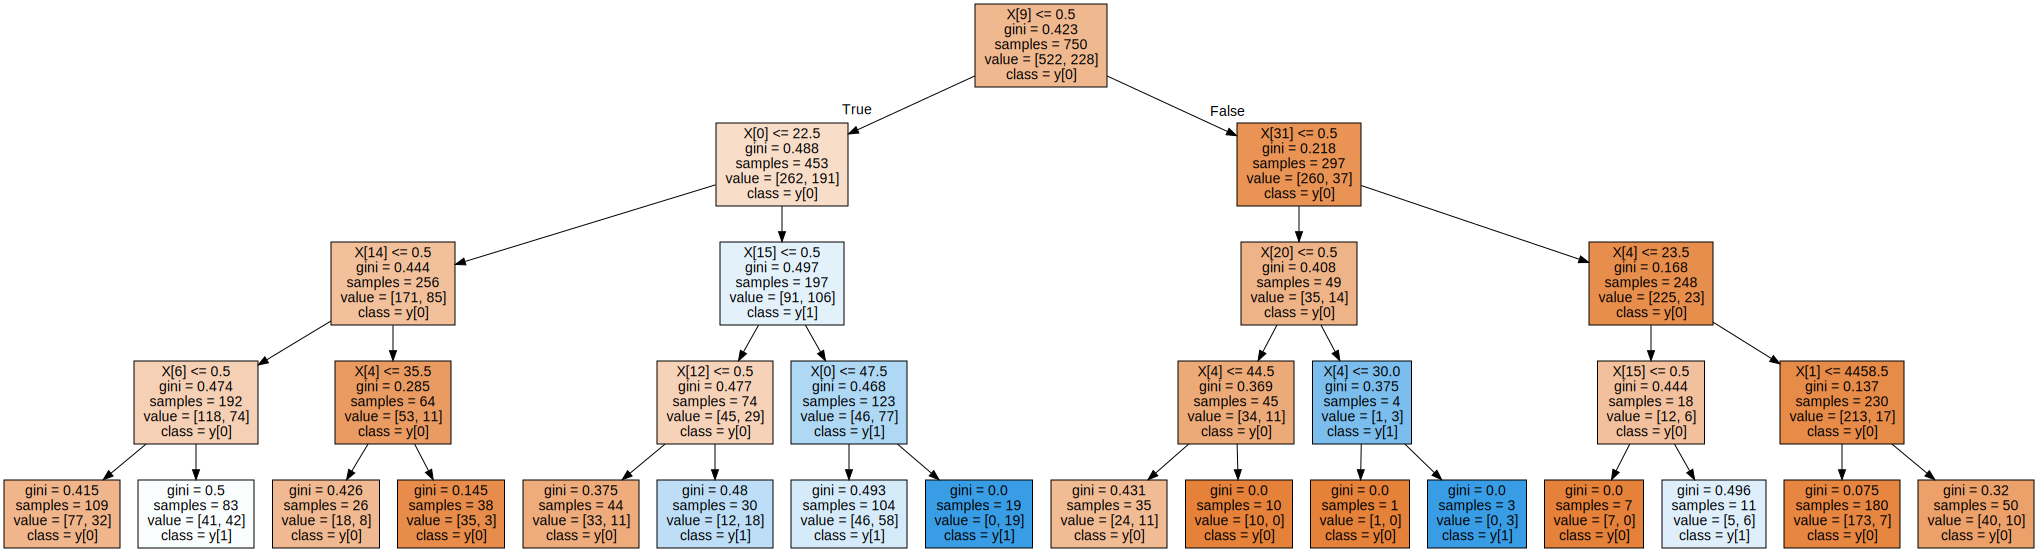

In [8]:
dot_data = tree.export_graphviz(dtc_model, out_file=None, filled=True, class_names=True)
graph = graphviz.Source(dot_data, format="png") 
graph

## 3. Display the text representation of the rules learnt.


In [9]:
features = X.columns[:36].tolist()
print(tree.export_text(dtc_model, feature_names=features))

|--- checkin_acc_A14 <= 0.50
|   |--- duration <= 22.50
|   |   |--- credit_history_A34 <= 0.50
|   |   |   |--- checkin_acc_A11 <= 0.50
|   |   |   |   |--- class: 0
|   |   |   |--- checkin_acc_A11 >  0.50
|   |   |   |   |--- class: 1
|   |   |--- credit_history_A34 >  0.50
|   |   |   |--- age <= 35.50
|   |   |   |   |--- class: 0
|   |   |   |--- age >  35.50
|   |   |   |   |--- class: 0
|   |--- duration >  22.50
|   |   |--- savings_acc_A61 <= 0.50
|   |   |   |--- credit_history_A32 <= 0.50
|   |   |   |   |--- class: 0
|   |   |   |--- credit_history_A32 >  0.50
|   |   |   |   |--- class: 1
|   |   |--- savings_acc_A61 >  0.50
|   |   |   |--- duration <= 47.50
|   |   |   |   |--- class: 1
|   |   |   |--- duration >  47.50
|   |   |   |   |--- class: 1
|--- checkin_acc_A14 >  0.50
|   |--- inst_plans_A143 <= 0.50
|   |   |--- present_emp_since_A71 <= 0.50
|   |   |   |--- age <= 44.50
|   |   |   |   |--- class: 0
|   |   |   |--- age >  44.50
|   |   |   |   |--- class: 